# Integrating surrogate gradients along closed path

Minimal example network
![setup.png](../setup.png)

In [3]:
import jax.numpy as jnp

import numpy as np
from scipy.stats import ortho_group

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from utils import net, grad_net

In [4]:
# Define colors

from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
silver = [230 / 255, 230 / 255, 230 / 255]  # RGB values for silver
dark_gray = [30 / 255, 30 / 255, 30 / 255]  # RGB values for dark gray

# Create a list of colors with a smooth transition from silver to dark gray
colors = [np.linspace(silver[i], dark_gray[i], 256) for i in range(3)]
colors = np.array(colors).T

# Create the custom colormap
gray_cmap = LinearSegmentedColormap.from_list("silver_to_dark_gray", colors, N=256)

yellow = "#EBB400"

## Define functions


In [5]:
# plotting


def contour(
    ax, x, y, z, levels=20, vmin=0, vmax=1, color="k", linewidths=0.5, cmap=gray_cmap
):
    im = ax.contourf(x, y, z, levels, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.contour(x, y, z, levels, colors=color, linewidths=linewidths)
    return im

In [6]:
def normalize(x):
    x = jnp.array(x)
    return (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))

In [7]:
def generate_circle_coordinates(radius, num_points):
    x_coords = []
    y_coords = []
    for i in range(num_points):
        angle = 2 * jnp.pi * i / num_points
        x = radius * jnp.sin(angle)
        y = radius * jnp.cos(angle)
        x_coords.append(x)
        y_coords.append(y)
    x_coords.append(x_coords[0])
    y_coords.append(y_coords[0])
    return jnp.array(x_coords), jnp.array(y_coords)

## Define parameters


In [8]:
preamble = "Plots/"

In [9]:
inp = jnp.array(1)
# weights = jnp.array([0.05, 0.025, -0.1, 0.05, 0.05])
weights = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0])

beta_sgs = [1, 5, 20]
beta = 10000

2024-05-03 10:17:39.465804: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
a_steps = jnp.linspace(-2, 2, 2000)
b_steps = jnp.linspace(-2, 2, 2000)

difference = {}
num_points = 1500
radius = 1.8

x_coords, y_coords = generate_circle_coordinates(radius, num_points)

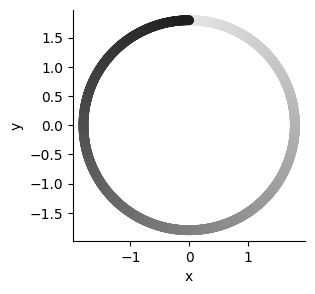

In [11]:
# plot circle coordinates
plt.figure(figsize=(3, 3))
plt.scatter(
    x_coords,
    y_coords,
    c=range(len(y_coords)),
    cmap=gray_cmap,
)
plt.xlabel("x")
plt.ylabel("y")
sns.despine()

In [12]:
# chose two random orthogonal directions to walk a closed circle on the loss landscape
seed = 124

m = ortho_group.rvs(5, random_state=seed)
d1 = jnp.array(list(m[0]))
d2 = jnp.array(list(m[1]))

d1 = m[0]
d2 = m[1]

d1 = d1 / jnp.linalg.norm(d1) * 1
d2 = d2 / jnp.linalg.norm(d2) * 1

print("Dot product:", jnp.dot(d1, d2))
print("Norm:", jnp.linalg.norm(d1), jnp.linalg.norm(d2))
print("d1:", d1)
print("d2:", d2)

Dot product: 2.7939677e-09
Norm: 1.0000001 1.0
d1: [ 0.1168134  -0.21802215 -0.8262966   0.5019748   0.06384699]
d2: [-0.30310827 -0.8068901   0.36749288  0.3028789   0.1739747 ]


## Plot network output


  0%|          | 0/4 [00:00<?, ?it/s]

0 1


 25%|██▌       | 1/4 [00:03<00:09,  3.20s/it]

1 5


 50%|█████     | 2/4 [00:06<00:06,  3.17s/it]

2 20


 75%|███████▌  | 3/4 [00:09<00:03,  3.29s/it]

3 10000


100%|██████████| 4/4 [00:12<00:00,  3.24s/it]


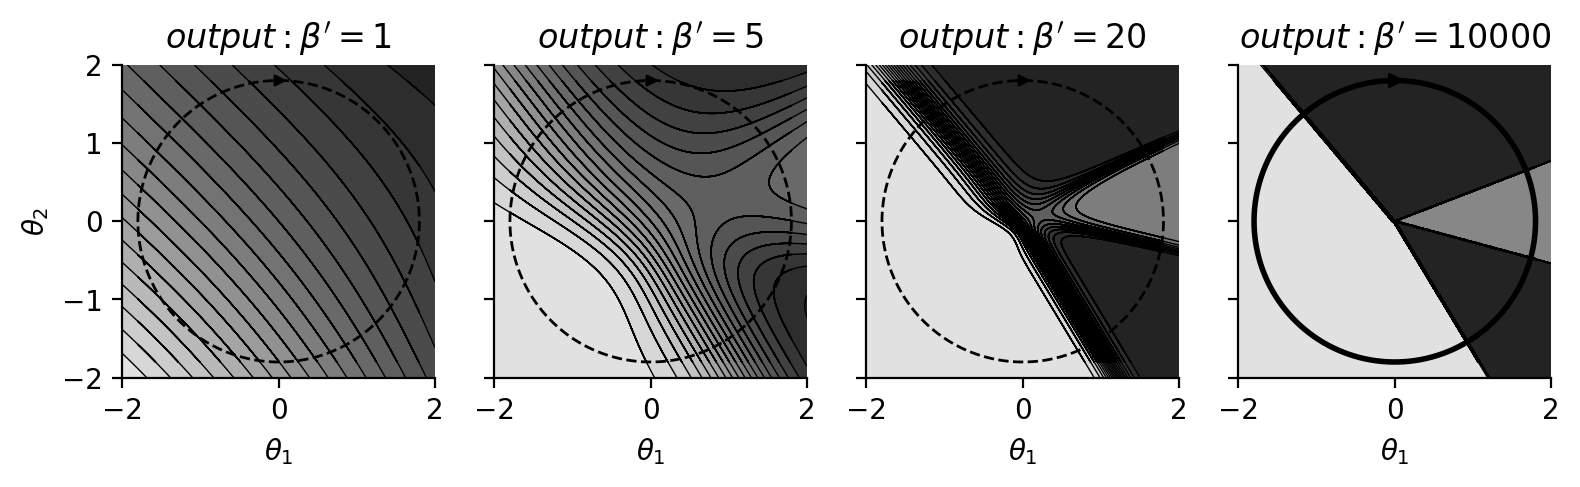

In [13]:
fig, ax = plt.subplots(
    1,
    len(beta_sgs) + 1,
    figsize=(2 * len(beta_sgs) + 2, 3),
    dpi=200,
    sharex=True,
    sharey=True,
    subplot_kw={"adjustable": "box", "aspect": 1},
)

y_dict = {}
y_smooth = {}
y_smooth_circle = {}

for i, beta_sg in enumerate(tqdm(beta_sgs + [beta])):
    y_s = net(weights, inp, x_coords, y_coords, d1, d2, beta_sg)
    y_smooth[beta_sg] = y_s

    y_s_circle = net(weights, inp, a_steps, b_steps, d1, d2, beta_sg)
    y_smooth_circle[beta_sg] = y_s_circle

    contour(
        ax[i],
        a_steps,
        b_steps,
        y_smooth_circle[beta_sg],
        vmin=None,
        vmax=None,
        cmap=gray_cmap,
        color="k",
    )

    contour(
        ax[i],
        x_coords,
        y_coords,
        y_smooth[beta_sg],
        vmin=None,
        vmax=None,
        cmap=gray_cmap,
        color="k",
    )

    ax[i].set_title(r"$output: \beta' = {}$".format(beta_sg))
    ax[i].set_xlabel(r"$\theta_1$")

    if i < len(beta_sgs):
        ax[i].plot(x_coords, y_coords, color="black", ls="--", lw=1)
        ax[i].scatter(x_coords[0], y_coords[0], color="black", s=11, marker=">")
    else:
        ax[i].plot(x_coords, y_coords, color="black", lw=2)
        ax[i].scatter(x_coords[0], y_coords[0], color="black", s=20, marker=">")


ax[0].set_ylabel(r"$\theta_2$")

plt.tight_layout()
sns.despine()

plt.savefig(preamble + "_out.svg")
plt.show()

## Plot integrated gradients along circle

In [14]:
circle_out = {}
circle_out_smooth = {}
circle_grad = {}
circle_grad_smooth = {}

for i, beta_sg in enumerate(beta_sgs):
    circle_out[beta_sg] = []
    circle_out_smooth[beta_sg] = []
    circle_grad[beta_sg] = []
    circle_grad_smooth[beta_sg] = []

    for x, y in tqdm(zip(x_coords, y_coords), total=num_points):
        out = net(weights, inp, jnp.array([x]), jnp.array([y]), d1, d2, beta)
        circle_out[beta_sg].append(out.item())

        out_s = net(weights, inp, jnp.array([x]), jnp.array([y]), d1, d2, beta_sg)
        circle_out_smooth[beta_sg].append(out_s.item())

        grads = grad_net(
            weights, inp, jnp.array([x]), jnp.array([y]), d1, d2, beta, beta_sg
        )
        circle_grad[beta_sg].append(grads[0, 0, :])

        grads_s = grad_net(
            weights, inp, jnp.array([x]), jnp.array([y]), d1, d2, beta_sg, beta_sg
        )
        circle_grad_smooth[beta_sg].append(grads_s[0, 0, :])

    circle_out[beta_sg] = jnp.array(circle_out[beta_sg])
    circle_out_smooth[beta_sg] = jnp.array(circle_out_smooth[beta_sg])
    circle_grad[beta_sg] = jnp.array(circle_grad[beta_sg])
    circle_grad_smooth[beta_sg] = jnp.array(circle_grad_smooth[beta_sg])

1501it [00:42, 35.17it/s]                          
1501it [00:41, 36.19it/s]                          
1501it [00:41, 36.43it/s]                          


In [15]:
circle_ig = {}
circle_ig_smooth = {}

for i, beta_sg in enumerate(beta_sgs):
    circle_ig[beta_sg] = []
    circle_ig_smooth[beta_sg] = []

    for j, (g, gs) in enumerate(zip(circle_grad[beta_sg], circle_grad_smooth[beta_sg])):
        weights_pre = weights + d1 * x_coords[j - 1] + d2 * y_coords[j - 1]
        weights_post = weights + d1 * x_coords[j + 1] + d2 * y_coords[j + 1]

        dir = weights_post - weights_pre
        dir /= jnp.linalg.norm(dir)

        ig = jnp.dot(dir, g)
        circle_ig[beta_sg].append(ig)

        ig_s = jnp.dot(dir, gs)
        circle_ig_smooth[beta_sg].append(ig_s)

    circle_ig[beta_sg] = jnp.array(circle_ig[beta_sg])
    circle_ig_smooth[beta_sg] = jnp.array(circle_ig_smooth[beta_sg])

100%|██████████| 3/3 [00:00<00:00,  9.37it/s]


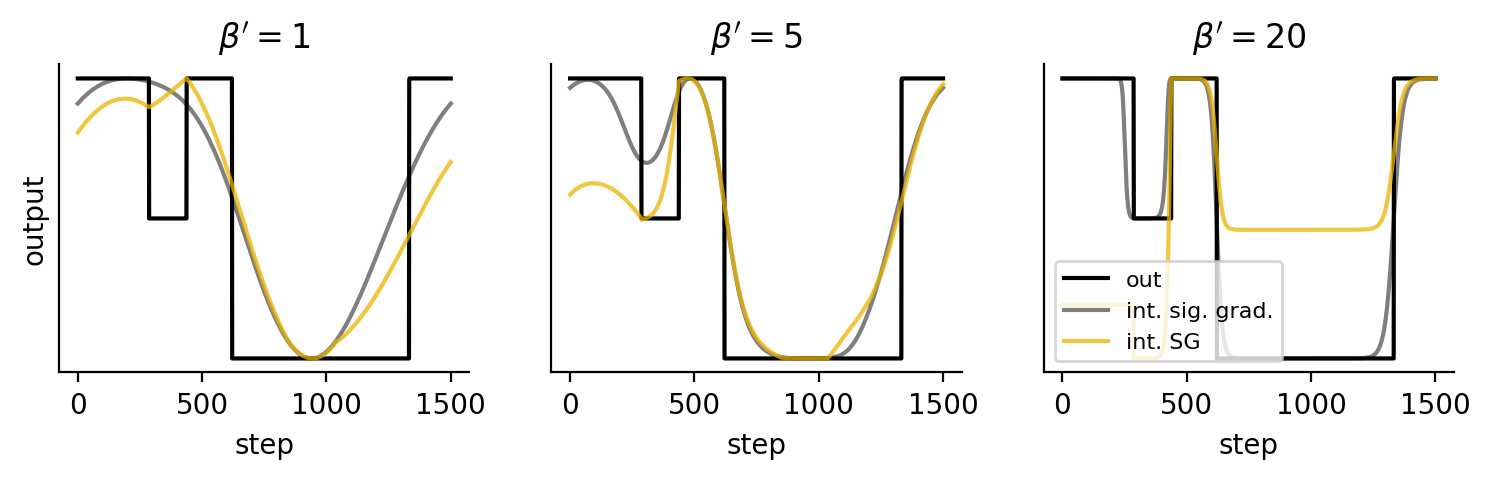

In [16]:
fig, ax = plt.subplots(
    1,
    len(beta_sgs),
    figsize=(3 * len(beta_sgs), 2),
    dpi=200,
    sharex=True,
    sharey=True,
)

for i, beta_sg in enumerate(tqdm(beta_sgs)):
    # ax[i].hlines(0, len(circle_out_smooth[beta_sg]), 0, linestyle="--", color="silver")
    ax[i].plot(normalize(circle_out[beta_sg]), color="black", label="out")
    ax[i].plot(
        normalize(jnp.cumsum(circle_ig_smooth[beta_sg])),
        color="black",
        alpha=0.5,
        label="int. sig. grad.",
    )
    ax[i].plot(
        normalize(jnp.cumsum(circle_ig[beta_sg])),
        color=yellow,
        alpha=0.75,
        label="int. SG",
    )

    ax[i].set_title(r"$\beta'= {}$".format(beta_sg))

    ax[i].set_xlabel("step")

ax[0].set_ylabel("output")
ax[0].set_yticks([])

ax[-1].legend(
    loc="lower left",
    fontsize=8,
)
sns.despine()

#### Plot integrated gradients along circle for different $\beta_{SG}$-values on same plot and scale all integrated SGs the same

100%|██████████| 3/3 [00:00<00:00, 175.66it/s]


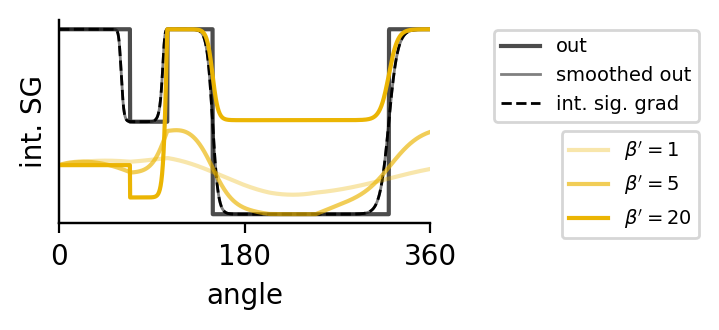

In [17]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(5.5, 1.75),
    dpi=200,
    sharex=True,
    sharey=True,
)

# plot on second y-axis
ax2 = ax.twinx()
ax.plot(circle_out[beta_sg], color="black", alpha=0.7, label="out", zorder=-10)
ax.plot(
    normalize(jnp.cumsum(circle_ig_smooth[beta_sg]) - 1),
    color="gray",
    lw=1,
    label="smoothed out",
    zorder=-11,
)
ax.plot(
    normalize(jnp.cumsum(circle_ig_smooth[beta_sg]) - 1),
    color="black",
    ls="--",
    lw=1,
    label="int. sig. grad",
    zorder=-10,
)
ax2.set_yticks([])

for i, beta_sg in enumerate(tqdm(beta_sgs)):
    # ax[i].hlines(0, len(circle_out_smooth[beta_sg]), 0, linestyle="--", color="silver")
    ax2.plot(
        jnp.cumsum(circle_ig[beta_sg]) - 1,
        color=yellow,
        alpha=0.33 * (i + 1),
        label=r"$\beta'= {}$".format(beta_sg),
    )

    ax.set_xlabel("angle")


ax.set_ylabel("int. SG")
ax.set_yticks([])

ax.legend(fontsize=7, loc="upper right", ncol=1, bbox_to_anchor=(1.75, 1.0))
ax2.legend(fontsize=7, loc="upper right", ncol=1, bbox_to_anchor=(1.75, 0.5))
sns.despine()
ax.set_xlim(0, num_points)
ax2.set_xlim(0, num_points)
ax.set_xticks([0, num_points / 2, num_points], [0, 180, 360])

plt.tight_layout()

plt.savefig(preamble + "_all_ig_circle.svg")